In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from typing import List
from pathlib import Path
from nifty_index import NIFTY_METAL as index_stocks

In [2]:
print(index_stocks)

['COALINDIA', 'HINDALCO', 'JINDALSTEL', 'JSWSTEEL', 'MOIL', 'NALCO', 'NMDC', 'RATNAMANI', 'SAIL', 'TATASTEEL', 'VEDL', 'WELCORP']


In [3]:
def load_signal_data(signal_dir: str = "../signal/se/equity", index_stocks: list = None) -> pd.DataFrame:
    """
    Loads all CSV signal files from the given directory (recursively),
    filters to include only index stock signals, and returns a cleaned DataFrame.
    
    Args:
        signal_dir (str): Path to the folder containing signal files.
        index_stocks (list): List of index stock symbols to filter. If None, loads all.

    Returns:
        pd.DataFrame: Combined signal DataFrame for index stocks.
    """
    signal_data = []
    signal_dir = Path(signal_dir)

    for file in signal_dir.rglob("*.csv"):
        try:
            df = pd.read_csv(file)
            if 'Symbol' in df.columns and not df.empty:
                df['Date'] = pd.to_datetime(df['Date'])
                signal_data.append(df)
        except Exception as e:
            print(f"❌ Failed to load {file}: {e}")

    if not signal_data:
        raise ValueError("No valid signal files found!")

    # Concatenate and clean
    full_df = pd.concat(signal_data, ignore_index=True)
    full_df.drop_duplicates(subset=["Date", "Symbol"], inplace=True)

    # Filter for index stocks
    if index_stocks is not None:
        full_df = full_df[full_df['Symbol'].isin(index_stocks)]

    # Set Date as Datetime
    full_df['Date'] = pd.to_datetime(full_df['Date'], format='%Y-%m-%d', errors='coerce')
    # Sort for time-series logic
    full_df.sort_values(by=["Date", "Symbol"], inplace=True)


    # Optional: select only required columns
    final_cols = ['Date', 'Symbol', 'Signal']
    available_cols = [col for col in final_cols if col in full_df.columns]
    return full_df[available_cols].reset_index(drop=True)


In [4]:
def load_price_data(signal_df: pd.DataFrame, index_stocks: List[str], data_dir: str = "../data/nse/equity") -> pd.DataFrame:
    """
    Load raw price data for only the dates and index stocks relevant to the signal DataFrame.

    Args:
        signal_df (pd.DataFrame): DataFrame with 'Date' column to extract required dates.
        index_stocks (List[str]): List of index stock symbols to filter.
        data_dir (str): Path to the root data directory containing year/date-based .csv.gz files.

    Returns:
        pd.DataFrame: Pivoted DataFrame with Date as index, Symbol as columns, Close price as values.
    """
    needed_dates = pd.to_datetime(signal_df['Date'].unique()).strftime('%Y%m%d')
    needed_years = set(date[:4] for date in needed_dates)

    all_prices = []

    for year in needed_years:
        year_path = Path(data_dir) / year
        if not year_path.exists():
            continue

        for date_str in needed_dates:
            if not date_str.startswith(year):
                continue

            file_path = year_path / f"{date_str}.csv.gz"
            if not file_path.exists():
                continue
            try:
                df = pd.read_csv(file_path, compression='gzip')
                df = df[df['TckrSymb'].isin(index_stocks)]
                df = df[['TradDt', 'TckrSymb', 'OpnPric', 'HghPric', 'LwPric', 'ClsPric', 'TtlTradgVol', 'TtlTrfVal', 'TtlNbOfTxsExctd']]
                df.columns = ['Date', 'Symbol', 'Open', 'High', 'Low', 'Close', 'Volume' , 'Value', 'Trans']
                df['Date'] = pd.to_datetime(df['Date'])

                # Remove duplicates if any
                df.drop_duplicates(subset=['Date', 'Symbol'], inplace=True)
                                            
                all_prices.append(df)
            except Exception as e:
                print(f"⚠️ Error loading {file_path}: {e}")

    if not all_prices:
        raise ValueError("No valid price data found for the selected dates.")

    # Combine and pivot
    price_df = pd.concat(all_prices, ignore_index=True)
    price_df.sort_values(['Date', 'Symbol'], inplace=True)

    return price_df

In [5]:
# Data parameters
signal_dir = "../signal/nse/equity"
data_dir = "../data/nse/equity"
# Backtest parameters
initial_capital = 1000000.0  # 10,00,000 INR
num_tranches = 10
tranche_size = initial_capital / num_tranches
commission = 0.0  # Assume no commission; add if needed

In [6]:
print("📥 Loading signal data...")
signals = load_signal_data(signal_dir, index_stocks)
# Verify unique Date-Symbol combination
duplicate_date_symbol = signals.duplicated(subset=['Date', 'Symbol']).sum()
if duplicate_date_symbol > 0:
    print(f"Error: {duplicate_date_symbol} duplicate Date-Symbol pairs found")
    print("Duplicate Date-Symbol rows:\n", signals[signals.duplicated(subset=['Date', 'Symbol'], keep=False)][['Date', 'Symbol', 'Signal']])
    raise ValueError("Date-Symbol combination must be unique")

print("💰 Preparing price data...")
prices = load_price_data(signals, index_stocks, data_dir)
# Verify unique Date-Symbol combination
duplicate_date_symbol = prices.duplicated(subset=['Date', 'Symbol']).sum()
if duplicate_date_symbol > 0:
    print(f"Error: {duplicate_date_symbol} duplicate Date-Symbol pairs found")
    print("Duplicate Date-Symbol rows:\n", prices[prices.duplicated(subset=['Date', 'Symbol'], keep=False)][['Date', 'Symbol', 'Signal']])
    raise ValueError("Date-Symbol combination must be unique")



📥 Loading signal data...
💰 Preparing price data...


In [7]:
# Filter data for the backtest period: Jan 1, 2025 to Sep 19, 2025 (adjust end date if needed)
start_date = pd.to_datetime('2025-01-20')
end_date = pd.to_datetime('2025-09-12')
prices = prices[(prices['Date'] >= start_date) & (prices['Date'] <= end_date)]
signals = signals[(signals['Date'] >= start_date) & (signals['Date'] <= end_date)]

# Check data availability
print("\nPrice data dates:", prices['Date'].min(), "to", prices['Date'].max(), f"({len(prices)} days)")
print("Signal data dates:", signals['Date'].min(), "to", signals['Date'].max(), f"({len(signals)} days)")
test_date = pd.to_datetime('2025-08-20')
if test_date in prices['Date'].values:
    print(f"{test_date.date()} found in prices")
else:
    print(f"{test_date.date()} NOT found in prices. Using first available date.")
if test_date in signals['Date'].values:
    print(f"{test_date.date()} found in signals")
else:
    print(f"{test_date.date()} NOT found in signals")


Price data dates: 2025-01-20 00:00:00 to 2025-09-12 00:00:00 (1771 days)
Signal data dates: 2025-01-20 00:00:00 to 2025-09-12 00:00:00 (1771 days)
2025-08-20 found in prices
2025-08-20 found in signals


In [8]:
# Align signals: Signal on date D applies to D+1
trading_days = prices['Date'].sort_values().unique()
signal_mapped = pd.DataFrame({'Date': trading_days, 'Signal': 'HOLD'})
for signal_date in signals['Date']:
    # Find the next trading day after signal_date
    next_trading_day = trading_days[trading_days > signal_date]
    if len(next_trading_day) > 0:
        next_day = next_trading_day[0]
        signal_value = signals[signals['Date'] == signal_date]['Signal'].iloc[0]
        signal_mapped.loc[signal_mapped['Date'] == next_day, 'Signal'] = signal_value

# Verify data
if len(prices) <= 1:
    raise ValueError("Insufficient price data")
if len(signal_mapped) == 0:
    raise ValueError("No aligned signals in the period")

In [9]:
# Backtest parameters
initial_capital = 1000000.0
num_tranches = 10
tranche_size = initial_capital / num_tranches
commission = 0.0

# Get unique symbols from signals
unique_symbols = signals['Symbol'].unique()
print("\nUnique symbols:", unique_symbols)

# Initialize tracking variables
cash = initial_capital
positions = {sym: {'shares': 0.0, 'tranches_used': 0} for sym in unique_symbols}
portfolio_history = []


Unique symbols: ['COALINDIA' 'HINDALCO' 'JINDALSTEL' 'JSWSTEEL' 'MOIL' 'NMDC' 'RATNAMANI'
 'SAIL' 'TATASTEEL' 'VEDL' 'WELCORP']


In [10]:
# Select first valid trading day
if len(trading_days) == 0:
    raise ValueError("No trading days available in the price data")
initial_date = trading_days[0]
if initial_date not in prices['Date'].values:
    raise ValueError(f"Initial date {initial_date.date()} not in prices")

# Debug: Verify initial_date
print(f"\nInitial date: {initial_date.date()}")
try:
    close_price = prices[prices['Date'] == initial_date]['Close'].iloc[0]
    print(f"Close price on initial date: {close_price}")
except IndexError:
    print(f"Error accessing Close price for {initial_date.date()}")
    raise


Initial date: 2025-01-20
Close price on initial date: 387.05


In [11]:
# Add initial portfolio state
initial_date = trading_days[0]
position_value = 0.0
for sym in unique_symbols:
    price_row = prices[(prices['Date'] == initial_date) & (prices['Symbol'] == sym)]
    if not price_row.empty:
        position_value += positions[sym]['shares'] * price_row['Close'].iloc[0]
portfolio_value = cash + position_value
portfolio_history.append({
    'Date': initial_date,
    'Cash': cash,
    'Position_Value': position_value,
    'Portfolio_Value': portfolio_value,
    'Tranches_Used': sum(p['tranches_used'] for p in positions.values())
})


In [12]:
# Backtest loop
for i in range(1, len(trading_days)):
    current_date = trading_days[i]
    previous_date = trading_days[i-1]  # Assume consecutive trading days; adjust if gaps

    # Process each symbol
    for sym in unique_symbols:
        # Get signal for this symbol from previous date
        signal_row = signals[(signals['Date'] == previous_date) & (signals['Symbol'] == sym)]
        if not signal_row.empty:
            signal = signal_row['Signal'].iloc[0].upper()
        else:
            signal = 'HOLD'

        # Get prices for this symbol on current date
        price_row = prices[(prices['Date'] == current_date) & (prices['Symbol'] == sym)]
        if price_row.empty:
            print(f"Skipping {sym} on {current_date.date()}: Missing price data")
            continue
        open_price = price_row['Open'].iloc[0]
        close_price = price_row['Close'].iloc[0]

        # Execute trade
        if signal == 'BUY' and positions[sym]['tranches_used'] < num_tranches and cash >= tranche_size:
            buy_amount = tranche_size
            shares_to_buy = buy_amount / open_price
            positions[sym]['shares'] += shares_to_buy
            cash -= buy_amount
            positions[sym]['tranches_used'] += 1
            print(f"BUY {sym} on {current_date.date()}: Bought {shares_to_buy:.2f} shares at {open_price:.2f}, Tranche {positions[sym]['tranches_used']}/{num_tranches}")

        elif signal == 'SELL' and positions[sym]['shares'] > 0:
            sell_proceeds = positions[sym]['shares'] * open_price
            cash += sell_proceeds
            print(f"SELL {sym} on {current_date.date()}: Sold {positions[sym]['shares']:.2f} shares at {open_price:.2f}")
            positions[sym]['shares'] = 0.0
            positions[sym]['tranches_used'] = 0

        elif signal == 'HOLD':
            pass

    # Calculate current portfolio value at close
    position_value = 0.0
    for sym in unique_symbols:
        price_row = prices[(prices['Date'] == current_date) & (prices['Symbol'] == sym)]
        if not price_row.empty:
            position_value += positions[sym]['shares'] * price_row['Close'].iloc[0]
    portfolio_value = cash + position_value

    # Record history
    portfolio_history.append({
        'Date': current_date,
        'Cash': cash,
        'Position_Value': position_value,
        'Portfolio_Value': portfolio_value,
        'Tranches_Used': sum(p['tranches_used'] for p in positions.values())
    })

BUY TATASTEEL on 2025-04-08: Bought 741.34 shares at 134.89, Tranche 1/10
BUY NMDC on 2025-04-09: Bought 1624.17 shares at 61.57, Tranche 1/10
BUY TATASTEEL on 2025-04-09: Bought 769.23 shares at 130.00, Tranche 2/10
BUY TATASTEEL on 2025-04-11: Bought 742.56 shares at 134.67, Tranche 3/10
SELL TATASTEEL on 2025-04-22: Sold 2253.13 shares at 142.00
SELL NMDC on 2025-05-09: Sold 1624.17 shares at 62.00
BUY NMDC on 2025-06-23: Bought 1477.10 shares at 67.70, Tranche 1/10
BUY TATASTEEL on 2025-06-23: Bought 664.45 shares at 150.50, Tranche 1/10
BUY NMDC on 2025-06-24: Bought 1444.04 shares at 69.25, Tranche 2/10
SELL NMDC on 2025-07-11: Sold 2921.15 shares at 69.00
SELL TATASTEEL on 2025-07-17: Sold 664.45 shares at 157.50
BUY SAIL on 2025-07-30: Bought 793.65 shares at 126.00, Tranche 1/10
BUY SAIL on 2025-08-04: Bought 828.78 shares at 120.66, Tranche 2/10
SELL SAIL on 2025-08-06: Sold 1622.43 shares at 124.89


Running Portfolio Tally:
          Date        Cash  Position_Value  Portfolio_Value  Tranches_Used
0   2025-01-20  1000000.00             0.0       1000000.00              0
1   2025-01-21  1000000.00             0.0       1000000.00              0
2   2025-01-22  1000000.00             0.0       1000000.00              0
3   2025-01-23  1000000.00             0.0       1000000.00              0
4   2025-01-24  1000000.00             0.0       1000000.00              0
..         ...         ...             ...              ...            ...
156 2025-09-08  1029478.21             0.0       1029478.21              0
157 2025-09-09  1029478.21             0.0       1029478.21              0
158 2025-09-10  1029478.21             0.0       1029478.21              0
159 2025-09-11  1029478.21             0.0       1029478.21              0
160 2025-09-12  1029478.21             0.0       1029478.21              0

[161 rows x 5 columns]


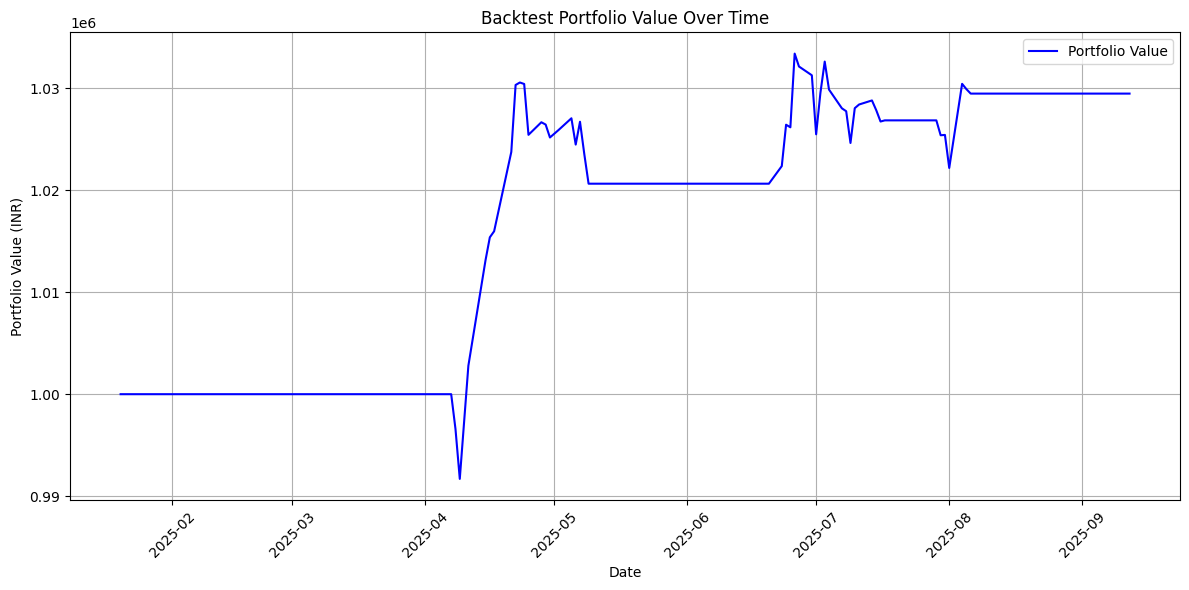

In [13]:
# Convert history to DataFrame
portfolio_df = pd.DataFrame(portfolio_history)

# Display running tally
print("Running Portfolio Tally:")
print(portfolio_df.round(2))

# Plot the portfolio value over time
plt.figure(figsize=(12, 6))
plt.plot(portfolio_df['Date'], portfolio_df['Portfolio_Value'], label='Portfolio Value', color='blue')
plt.title('Backtest Portfolio Value Over Time')
plt.xlabel('Date')
plt.ylabel('Portfolio Value (INR)')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [14]:
# Portfolio Summary
final_value = portfolio_df['Portfolio_Value'].iloc[-1]
total_return = ((final_value - initial_capital) / initial_capital) * 100
num_days = (portfolio_df['Date'].iloc[-1] - portfolio_df['Date'].iloc[0]).days
cagr = ((final_value / initial_capital) ** (365 / num_days) - 1) * 100 if num_days > 0 else 0

# Simple returns for Sharpe (daily returns, assume risk-free rate = 0)
daily_returns = portfolio_df['Portfolio_Value'].pct_change().dropna()
sharpe_ratio = (daily_returns.mean() / daily_returns.std()) * np.sqrt(252) if daily_returns.std() != 0 else 0

# Count trades (approximate: number of BUY + SELL signals)
num_buys = len(signals[signals['Signal'] == 'BUY'])
num_sells = len(signals[signals['Signal'] == 'SELL'])
num_trades = num_buys + num_sells

summary = {
    'Initial Capital': f"{initial_capital:,.2f} INR",
    'Final Portfolio Value': f"{final_value:,.2f} INR",
    'Total Return (%)': f"{total_return:.2f}%",
    'CAGR (%)': f"{cagr:.2f}%",
    'Sharpe Ratio': f"{sharpe_ratio:.2f}",
    'Number of Trading Days': len(portfolio_df),
    'Number of BUY Signals': num_buys,
    'Number of SELL Signals': num_sells,
    'Total Trades': num_trades,
    'Max Tranches Used': portfolio_df['Tranches_Used'].max()
}

print("\nPortfolio Summary:")
for key, value in summary.items():
    print(f"{key}: {value}")


Portfolio Summary:
Initial Capital: 1,000,000.00 INR
Final Portfolio Value: 1,029,478.21 INR
Total Return (%): 2.95%
CAGR (%): 4.62%
Sharpe Ratio: 1.43
Number of Trading Days: 161
Number of BUY Signals: 9
Number of SELL Signals: 563
Total Trades: 572
Max Tranches Used: 4
